In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Scenario: 
    '''
    This class contains the simulation Scenario
    '''

    def __init__(self,table_arrangement,demand_duration=3,allow_sharing=1):

        self.prob_leave_q = {
            0: 0,
            1: 0.1,
            2:0.3,
            3:0.4,
            4:0.5
        }

        self.table_arrangement = {
            2:table_arrangement[0],
            3:table_arrangement[1],
            4:table_arrangement[2],
            5:table_arrangement[3]
        }

        self.arriving_rate = np.array([
                                        [1,8,3],
                                        [2,14,20],
                                        [3,11,15],
                                        [4,9,13],
                                        [4,7,14]])
        self.demand_duration = demand_duration
        self.sharing=allow_sharing
class Customers:
    def __init__(self,ID,size,time):
        self.customer_id = ID
        self.group_size = size
        self.time_arrival = time
        
        self.departure_time = 0
        self.seated_time = np.inf
        
        self.in_q = False 
        self.waiting_time = 0
        self.shared = False
        self.revenue = 0
        self.table = np.nan
        self.left = False

    def Seated(self,time,table,shared = False):
        self.seated_time = time
        self.shared = shared
        self.in_q = False
        self.table = table
        
    def Queueing(self,time):
        self.waiting_time += (time-self.time_arrival) 
        self.in_q = True
    
    def Left(self):
        self.seated_time  = 0
        self.in_q = False
        self.left = True
    
    def Departure(self,time):
        draw_time = np.min(((40+exponential_rng(lam = 1/20))/60,2))
        
        if(self.shared == True):
            draw_time = draw_time*0.5

        self.departure_time = self.seated_time + draw_time
        
    def Departure_updated(self,time):
        self.shared = True
        #compute remain time 
        remain_time = (self.departure_time-time)
        self.departure_time =  time + remain_time*0.5 
    
    def Revenue(self):
        amount = (np.random.uniform(0.5,1.2,self.group_size)*60*(self.departure_time-self.seated_time)).sum()
        if(self.shared == True):
            amount = 0.8*amount
            
        self.revenue = amount 
        
class Tables:
    def __init__(self,ID,size):
        self.table_id = ID
        self.table_size = size
        
        self.busy_seats = 0
        self.available_seats = size
        self.assigned_customer = []
        self.shared = False

    def Assigned_customer(self,customer_ID,group_size):
        customer_assigned = self.assigned_customer
        customer_assigned.extend([customer_ID])
        
        self.assigned_customer = customer_assigned
        if(len(self.assigned_customer)>1):
            self.shared = True
        
        new_busy_seats = self.busy_seats + group_size
        if(new_busy_seats>self.table_size):
            print('Total assigned group exceeds table occupancy')
        
        new_available_seats = self.available_seats-group_size
        
        self.busy_seats = new_busy_seats
        self.available_seats = new_available_seats
        
    def Removed_customer(self,customer_ID, group_size):
        new_assigned_customer = self.assigned_customer
        index = new_assigned_customer.index(customer_ID)
        new_assigned_customer.pop(index)
        
        if(len(new_assigned_customer) == 1):
            self.shared = False
            
        self.assigned_customer = new_assigned_customer
        self.busy_seats = self.busy_seats - group_size
        self.available_seats = self.available_seats + group_size
        
class Event:
    def __init__(self,time):
        self.time=time
        
class Arrival(Event):
    def __init__(self,time,customer_ID):
        super().__init__(time)
        self.id=customer_ID
        
class Abandon(Event):
    def __init__(self,time,customer_ID):
        super().__init__(time)
        self.id=customer_ID
    
class Departure(Event):
    def __init__(self,time,customer_ID):
        super().__init__(time)
        self.id=customer_ID
    
class Termination(Event):
    def __init__(self,time):
        super().__init__(time)
        
def exponential_rng(lam=1.0):
    """ Generates exponential random numbers.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
    
    Returns:
        exponential random numbers with rate lam
    """
    return -(1/lam)*np.log(np.random.rand())

def customer_arrival(t,arriving_rate):
    non_hom_rate = 0
    while non_hom_rate == 0:
        rate = arriving_rate[:,int(np.floor(t))].sum()
        arrival_time = t + exponential_rng(rate) 
        if(np.floor(arrival_time) == np.floor(t)):
            non_hom_rate = 1
        else:
            t = np.floor(t)+1
            if(t == 3):
                arrival_time=np.inf
                group_size=0
                non_hom_rate = 1
                return arrival_time,group_size
    
    draw = np.random.rand()
    non_hom_rate=0
    index=0
    while non_hom_rate==0:
        if draw < arriving_rate[:index,int(np.floor(t))].sum()/rate:
            non_hom_rate = 1
            group_size = index 
        index += 1
    return arrival_time,group_size

def customer_abondan(scenario,time,customers,customer_index):
    p = np.random.uniform()
    
    time_interval = time - customers[customer_index].time_arrival
    
    if(time_interval< 5/60):
        prob_leaving = scenario.prob_leave_q[1]
    elif(time_interval< 10/60):
        prob_leaving = scenario.prob_leave_q[2]
    elif(time_interval< 20/60):
        prob_leaving = scenario.prob_leave_q[3]
    else:
        prob_leaving = scenario.prob_leave_q[4]
        
    if(p<prob_leaving):
        new_event_time = -1 
    else:
        new_event_time = time + 5/60
        
    return new_event_time

def seating_strategy_allocation(scenario,time,tables,customers,customer_index,q,events):
    '''
    Scenario:
    
    1) Empty table to fit group
    2) No empty tables but enough seats in other tables 
    3) No seats to fit group
    
    Action:
    
    1) Assign customer to empty table (try to match group size to table size)
    2) Assign group to a shared table (minimize empty seat in shared table)
    3) Assign group to q 
    '''
    
    group = customers[customer_index]
    group_size = group.group_size
    
    #Scenratio 1, 2 ,3 
    empty_tables = [x for x in tables if ((x.busy_seats == 0) and ((x.available_seats - group_size) >= 0))] 
    shared_tables = [x for x in tables if ((x.available_seats - group_size) >= 0)] 
    
    if(empty_tables):
        #match table size to group size or assigned to the best option
        empty_tables.sort(key = lambda x:x.available_seats - group_size ,reverse=False) 
        tables[empty_tables[0].table_id].Assigned_customer(customer_index,group_size)
        if(customers[customer_index].in_q == True):
            q-=1
        customers[customer_index].Seated(time,empty_tables[0].table_id)
        customers[customer_index].Departure(time)
        departure = Departure(customers[customer_index].departure_time,customer_index)
        events.append(departure)
        
        #remove previous abondon event
        for event_n in range(len(events)):
            if(isinstance(events[event_n],Abandon)):
                if(events[event_n].id == customer_index):
                    events.pop(event_n)
                    break
        
        
    elif(shared_tables and scenario.sharing==1):
        #minimize the number of empty seats in shared table
        shared_tables.sort(key = lambda x:x.available_seats - group_size ,reverse=False)
        tables[shared_tables[0].table_id].Assigned_customer(customer_index,group_size)
        
        if(customers[customer_index].in_q == True):
            q-=1
            
        customers[customer_index].Seated(time,shared_tables[0].table_id,True)
        customers[customer_index].Departure(time)
        departure = Departure(customers[customer_index].departure_time,customer_index)
        events.append(departure)
        
        #remove previous abondon event
        for event_n in range(len(events)):
            if(isinstance(events[event_n],Abandon)):
                if(events[event_n].id == customer_index):
                    events.pop(event_n)
                    break
        

        for c_id in tables[shared_tables[0].table_id].assigned_customer:
            if(c_id != customer_index):
                if(customers[c_id].shared == False):
                    
                    #remove previous departure event
                    for event_n in range(len(events)):
                        if(isinstance(events[event_n],Departure)):
                            if(events[event_n].id == c_id):
                                events.pop(event_n)
                                break
                    customers[c_id].Departure_updated(time)
                    departure = Departure(customers[c_id].departure_time,c_id)
                    events.append(departure)
                    
    elif(customers[customer_index].in_q == False):
        ##Before check if he want's to leavee!!!!
        new_abandon = customer_abondan(scenario,time,customers,customer_index)
        if(new_abandon != -1):
            if(customers[customer_index].waiting_time == 0):
                q += 1

            customers[customer_index].Queueing(new_abandon)
            abandon = Abandon(new_abandon,customer_index)
            events.append(abandon)
        else:
            customers[customer_index].Left()

    return tables , customers , q , events 

In [2]:
def simulate(scenario):
    tables = []
    ID = 0
    for table_size in scenario.table_arrangement:
        for i in range(scenario.table_arrangement[table_size]):
            table = Tables(ID,table_size) 
            tables.append(table)
            ID += 1

    ID = 0
    queue=0
    times=[0]
    queues=[0]

    time, group_size = customer_arrival(0,scenario.arriving_rate)

    generation=Arrival(time,ID)
    termination=Termination(scenario.demand_duration)
    events=[generation,termination]

    customers = []
    customer = Customers(ID,group_size,time) 
    customers.append(customer)
    while len(events):
        e=events[0]
        if isinstance(e,Arrival):
            times.append(e.time)
            tables,customers,queue,events = seating_strategy_allocation(scenario,e.time,tables,customers,e.id,queue,events)
            queues.append(queue)
            #next arrival
            time, group_size = customer_arrival(e.time,scenario.arriving_rate)
            if(time<scenario.demand_duration):
                ID += 1
                generation=Arrival(time,ID)
                events.append(generation)
                customer = Customers(ID,group_size,time) 
                customers.append(customer)

        elif isinstance(e,Abandon):
            times.append(e.time)
            new_abandon = customer_abondan(scenario,e.time,customers,e.id)
            if(new_abandon != -1):
                abandon = Abandon(new_abandon,e.id)
                events.append(abandon)
            else:
                queue -=1
                customers[e.id].Left()
            queues.append(queue)

        elif isinstance(e,Departure):
            times.append(e.time)
            #Todo compute revenue and remove customer from table
            customers[e.id].Revenue()
            tables[customers[e.id].table].Removed_customer(e.id,customers[e.id].group_size)


            queing_customer = [x for x in customers if (x.in_q == True)]
            queing_customer.sort(key = lambda x:x.time_arrival,reverse=False) 
            for j in range(len(queing_customer)):
                tables,customers,queue,events = seating_strategy_allocation(scenario,e.time,tables,customers,queing_customer[j].customer_id,queue,events)

            queues.append(queue)

        elif isinstance(e,Termination):
            pass

        events.pop(0)
        events.sort(key=lambda event:event.time)
    return times, queues , tables, customers




In [3]:
def average_simulate(table_arrangement,k):
    Revenue = 0
    Revenues=[]
    scenario = Scenario(table_arrangement)
    for i in range(k):
        times, queues , tables, customers= simulate(scenario)
        revenue_list = [x.revenue for x in customers if (x.revenue > 0)]
        gross_rev = np.array(revenue_list).sum()
        expenses = times[-1]*0.1*60*sum(np.array(list(scenario.table_arrangement.items()))[:,0]*np.array(list(scenario.table_arrangement.items()))[:,1])
        Revenue += gross_rev-expenses
        Revenues.append(gross_rev-expenses)
#         print(gross_rev-expenses)

    return  Revenue/k, Revenues

In [4]:
u_0=[50,0,0,20]
f, temp = average_simulate(u_0,5000);


Mean = 9844.81
Std = 1081.12


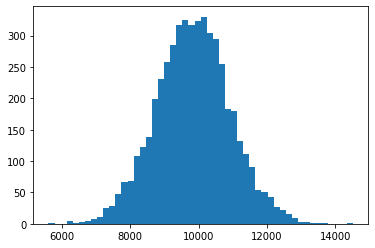

In [5]:
plt.hist(temp, bins=50)
print("Mean = ",end="")
print("{:.2f}".format(f))
print("Std = ",end="")
print("{:.2f}".format(np.std(temp)))